### TODO:

#### Code

1. Train multiple class model
    1. Different anchor boxes
    - Scale == 1500?
    - See "A closer look at Faster R-CNN for vehicle detection"
1. Repeat all experiments with multiple class object detector

1. Example images of poor detections

1. Risk-Coverage plots
1. AP with each method
1. ~~Runtime statistics for a single prediction for each method~~

1. Rerun experiments for False positive detection

1. More correct Mahalanobis with input perturbation?


#### Other stuff

1. Remove Steve as co-supervisor
1. Email grad director for two-week display period
1. Agreement to read form

#### Writing

1. Finish results
1. Finish experimental setup
1. Write conclusion/discussion
1. Add more background on AnDet techniques
1. Rewrite intro sections
1. Edit edit edit

In [1]:
%cd ..

/home/tadenoud/Git/simple-faster-rcnn-pytorch


In [2]:
RANDOM_SEED = 42
SUBSET_SAMPLE_DATA_PERCENTAGE = 0.1
MIN_IOU_REQUIRED = 0.7  # The minimum IOU required to be a good detection (ie higher is more strict)
NUM_PROPOSALS = 300
CHECKPOINT_DIR = './idd_cars_drop_checkpoints_with_nms'

%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import torch as t
from model import FasterRCNNVGG16
from trainer import FasterRCNNTrainer
import numpy as np
import pickle
import h5py
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

from data.util import  read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
from utils.config import opt
from utils.idd_utils import get_annotations
from model.utils.bbox_tools import bbox_iou

from data.dataset import Dataset, TestDataset, KittiDataset
from torch.utils.data import DataLoader
from utils.vis_tool import vis_bbox, vis_image
from utils.idd_utils import IndiaDrivingDataset
from ood_metrics import auroc, plot_roc, calc_metrics
from sklearn import svm
import pickle
import itertools
import torch
from model.faster_rcnn import nograd
from data.dataset import preprocess
from utils.mahalanobis import Mahal_Dist


import warnings
warnings.filterwarnings(action='once')

np.random.seed(RANDOM_SEED)

In [3]:
opt.voc_data_dir = "/media/tadenoud/DATADisk/datasets/kitti_2d/VOC2012/"
idd_data_dir = "/media/tadenoud/DATADisk/datasets/idd_detection/IDD_Detection/"

kitti_train_dataset = KittiDataset(opt, split='train')
kitti_val_dataset = KittiDataset(opt, split='val')
idd_val_dataset = IndiaDrivingDataset(idd_data_dir, split='val')

# Full datasets samples
kitti_train_samples = len(kitti_train_dataset)
kitti_val_samples = len(kitti_val_dataset)
idd_val_samples = len(idd_val_dataset)

# Subset Datasets
subset_kitti_train_samples = round(len(kitti_train_dataset) * SUBSET_SAMPLE_DATA_PERCENTAGE)
subset_kitti_val_samples = round(len(kitti_val_dataset) * SUBSET_SAMPLE_DATA_PERCENTAGE)
subset_idd_val_samples = round(len(idd_val_dataset) * SUBSET_SAMPLE_DATA_PERCENTAGE)

SUBSET_KITTI_TRAIN_TO_USE = np.random.choice(subset_kitti_train_samples, subset_kitti_train_samples, replace=False)
SUBSET_KITTI_VAL_TO_USE = np.random.choice(subset_kitti_val_samples, subset_kitti_val_samples, replace=False)
SUBSET_IDD_VAL_TO_USE = np.random.choice(subset_idd_val_samples, subset_idd_val_samples, replace=False)

# Subset of full datasets
subset_kitti_train_dataset = torch.utils.data.Subset(kitti_train_dataset, SUBSET_KITTI_TRAIN_TO_USE)
subset_kitti_val_dataset = torch.utils.data.Subset(kitti_val_dataset, SUBSET_KITTI_VAL_TO_USE)
subset_idd_val_dataset = torch.utils.data.Subset(idd_val_dataset, SUBSET_IDD_VAL_TO_USE)

In [4]:
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn, visdom=False).cuda()

# Load model trained with caffe pretrained model


In [5]:
%ls ./checkpoints/cars_drop/

fasterrcnn_11060017_0.7454640828611436  fasterrcnn_11061638_0.7497252402944325
fasterrcnn_11061427_0.7282598515502949  fasterrcnn_11061705_0.7526206908232453
fasterrcnn_11061454_0.733123502219126   fasterrcnn_11062316_0.7550167879591324
fasterrcnn_11061507_0.7394557961451338


In [6]:
save_dir = './checkpoints/cars_drop'
trainer.load(os.path.join(save_dir, 'fasterrcnn_11062316_0.7550167879591324'))
trainer.faster_rcnn.eval()

FasterRCNNVGG16(
  (extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

In [7]:
string_dt = h5py.string_dtype(encoding='utf-8')
feature_layer_sizes = (512, 4096, 4096)

In [8]:
def extract_kitti_features(dataset, model, save_file, perturbation=0, temperature=1):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)
    
    with h5py.File(save_file, "w") as f:
        for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))

            sizes = [sizes[0][0].item(), sizes[1][0].item()]
            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)

            # Get predictions and all classifier features
            res = model.predict_with_features(imgs, visualize=True, perturbation=perturbation, temperature=temperature)
            pred_bboxes, pred_labels, pred_scores, pred_features = res
            pred_bboxes, pred_labels, pred_scores, pred_features = \
                    pred_bboxes[0], pred_labels[0], pred_scores[0], pred_features[0]

            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))
            
            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels

            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            d.create_dataset("pred_boxes", data=pred_bboxes)
            d.create_dataset("pred_scores", data=pred_scores)
            d.create_dataset("pred_labels", data=pred_labels)
            d.create_dataset("pred_num_detections", data=len(pred_bboxes))
            d.create_dataset("pred_max_ious", data=max_ious) 
            d.create_dataset("pred_label_correct", data=pred_label_correct) 

            for j, feats in enumerate(pred_features):
                d.create_dataset("pred_features_" + str(j), data=feats)
                
                
def extract_idd_features(dataset, model, save_file, perturbation=0, temperature=1):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)

    with h5py.File(save_file, "w") as f:
        for i, (imgs, gt_bboxes, gt_labels) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))
            
            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)

            # Get predictions and all classifier features
            res = model.predict_with_features(imgs, visualize=True, perturbation=perturbation, temperature=temperature)
            pred_bboxes, pred_labels, pred_scores, pred_features = res
            pred_bboxes, pred_labels, pred_scores, pred_features = \
                    pred_bboxes[0], pred_labels[0], pred_scores[0], pred_features[0]

            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))

            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels

            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            d.create_dataset("pred_boxes", data=pred_bboxes)
            d.create_dataset("pred_scores", data=pred_scores)
            d.create_dataset("pred_labels", data=pred_labels)
            d.create_dataset("pred_num_detections", data=len(pred_bboxes))
            d.create_dataset("pred_max_ious", data=max_ious) 
            d.create_dataset("pred_label_correct", data=pred_label_correct) 

            for j, feats in enumerate(pred_features):
                d.create_dataset("pred_features_" + str(j), data=feats)
                

def show_max_ious_dist(data_file):
    """
    Given a data file generated by one of the feature_extractor functions, show the distribution 
    of IOUs with the gt data.
    """
    total_false_positives = 0
    all_max_ious = np.array([])

    with h5py.File(data_file, "r") as f:
        dset_length = len(f)
        for i in range(dset_length):
            max_ious = f[str(i)]["pred_max_ious"][()]

            false_positives = (max_ious < MIN_IOU_REQUIRED)
            total_false_positives += sum(false_positives)

            all_max_ious = np.concatenate((all_max_ious, max_ious), axis=0)

    plt.hist(all_max_ious, bins=50)
    plt.ylabel("Count")
    plt.xlabel("Max IOUS")
    plt.show()

    total_detections = len(all_max_ious)
    print("Total false positives (< %.2f) IoU: %d" % (MIN_IOU_REQUIRED, total_false_positives))
    print("Total detections: %d" % (total_detections))
    print("Total false positives (< %.2f) IoU: %f%%" % (MIN_IOU_REQUIRED, float(total_false_positives)/float(total_detections)*100))
    

def read_features(save_file, feature_idx, start=0, end=None, leave=True):
    """
    Read the features from the extracted HD5F feature file and return them as a numpy array
    along with a label array y describing if the features correspond to a high IOU gt box with
    the same classification as the prediction.
    """
    with h5py.File(save_file, "r") as f:       
        X = None
        y = np.empty((0,))
        
        if end is None or end > len(f):
            end = len(f)
        
        for i in trange(start, end, leave=leave):
            d = f[str(i)]
            features = d["pred_features_%d" % feature_idx][()]
            
            if X is None:
                # Initialize X array to correct size
                X = np.copy(features)
            else:
                X = np.concatenate((X, features), axis=0)
            
            label_is_car = d["pred_labels"][()] == 0
            iou_is_high_enough = d["pred_max_ious"][()] >= MIN_IOU_REQUIRED
            classification_is_correct = d["pred_label_correct"][()] == 1

            # Determine if each bbox is a high accuracy, correct class case
            label = label_is_car & iou_is_high_enough & classification_is_correct
            y = np.concatenate((y, label.astype(np.int)), axis=0)
            
    return X, y


def read_scores(save_file, start=0, end=None, leave=True):
    """
    Read the max_softmax scores from the extracted HD5F feature file and return them as a numpy array
    along with a label array y describing if the features correspond to a high IOU gt box with
    the same classification as the prediction.
    """
    with h5py.File(save_file, "r") as f:       
        X = None
        y = np.empty((0,))
        
        if end is None or end > len(f):
            end = len(f)
            
        for i in trange(start, end, leave=leave):
            d = f[str(i)]
            features = d["pred_scores"][()]
            
            if X is None:
                # Initialize X array to correct size
                X = np.copy(features)
            else:
                X = np.concatenate((X, features), axis=0)
            
            label_is_car = d["pred_labels"][()] == 0
            iou_is_high_enough = d["pred_max_ious"][()] >= MIN_IOU_REQUIRED
            classification_is_correct = d["pred_label_correct"][()] == 1

            # Determine if each bbox is a high accuracy, correct class case
            label = label_is_car & iou_is_high_enough & classification_is_correct
            y = np.concatenate((y, label.astype(np.int)), axis=0)
            
    return X, y

# Extract classifier features


#### Kitti Train

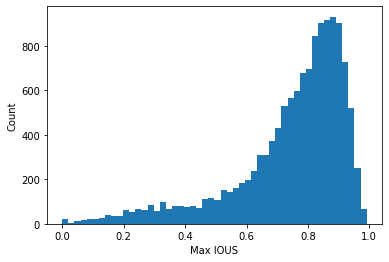

Total false positives (< 0.70) IoU: 3695
Total detections: 13115
Total false positives (< 0.70) IoU: 28.173847%


In [9]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train.hdf5")

if False:
    extract_kitti_features(kitti_train_dataset, trainer.faster_rcnn, save_path)

show_max_ious_dist(save_path)

#### Kitti Val


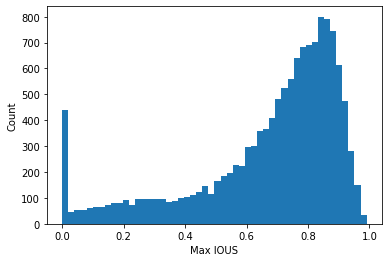

Total false positives (< 0.70) IoU: 5409
Total detections: 13424
Total false positives (< 0.70) IoU: 40.293504%


In [10]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")

if False:
    extract_kitti_features(kitti_val_dataset, trainer.faster_rcnn, save_path)

show_max_ious_dist(save_path)

#### IDD Val

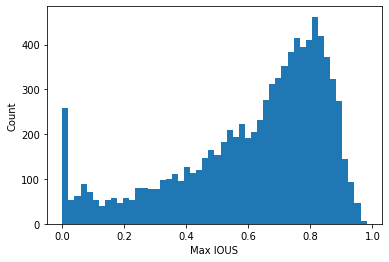

Total false positives (< 0.70) IoU: 4670
Total detections: 8878
Total false positives (< 0.70) IoU: 52.601937%


In [11]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")

if False:
    extract_idd_features(idd_val_dataset, trainer.faster_rcnn, save_path)

show_max_ious_dist(save_path)

# Get image with poor detections

In [12]:
def f(data_file):
    total_false_positives = 0
    all_max_ious = []

    with h5py.File(data_file, "r") as f:
        dset_length = len(f)
        for i in range(dset_length):
            max_ious = f[str(i)]["pred_max_ious"][()]

            false_positives = (max_ious < MIN_IOU_REQUIRED)
            total_false_positives += sum(false_positives)

            all_max_ious.append(max_ious)
    
    return all_max_ious

In [13]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")
kitti_val_max_ious = f(save_path)

In [14]:
kitti_val_max_ious

[array([0.37483976, 0.53805882]),
 array([0.84793252]),
 array([0.70691391, 0.51743985, 0.18741743, 0.30240544]),
 array([0.8795984 , 0.81242557, 0.77731192]),
 array([0.90751755, 0.87417061, 0.81636105, 0.68020331, 0.94123819,
        0.46714575, 0.67025004]),
 array([0.94374969, 0.01556203]),
 array([ 0.85610632, -0.        ,  0.24617708,  0.68413427]),
 array([ 0.84172706, -0.        ]),
 array([0.63140202, 0.71567896, 0.77633462, 0.75757131]),
 array([0.5230138 , 0.50280706]),
 array([0.56057677, 0.63520156]),
 array([0.86574193, 0.72811775, 0.82933759, 0.59707045]),
 array([-0.]),
 array([0.85419227, 0.8624064 , 0.88829254, 0.68678224, 0.87229441,
        0.08913276]),
 array([0.93665903, 0.34008601]),
 array([0.88849079, 0.92342603, 0.65115273]),
 array([0.85852908, 0.77480662]),
 array([0.86787014, 0.84040937, 0.707991  , 0.68299072]),
 array([0.61967205, 0.64639706]),
 array([0.61637688]),
 array([0.82373666, 0.88910367, 0.72197322, 0.79216682]),
 array([0.87273169, 0.85230347,

In [15]:
avgs = [x.mean() for x in kitti_val_max_ious]

/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.
/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [26]:
print(np.nanargmin(avgs))
print(np.nanmin(avgs))
print(kitti_val_max_ious[np.nanargmin(avgs)])
idx = np.nanargmin(avgs)

12
0.0
[-0.]


In [33]:
worst_pred_idx = sorted([(idx, miou) for idx, miou in enumerate(avgs)], key=lambda x: x[1])

In [ ]:
import matplotlib.patches as patches

def display_img(idx, dset, save_path):
    # Create figure and axes
    fig,ax = plt.subplots(1, figsize=(20,20))
    
    # Get GT data
    img, boxes, labels, _ = dset.db[idx]
    
    # Get pred data
    pred_boxes, pred_labels, pred_scores = trainer.faster_rcnn.predict([img], visualize=True)    

    # Display the image
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 0, 1).astype(np.int)
    ax.imshow(img)
    
    # Display pred patches
    for b in pred_boxes[0]:
        y1, x1, y2, x2 = b
        rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=2,edgecolor='g',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
    
    # Display GT patches
    for b in boxes[labels!=-1]:
        y1, x1, y2, x2 = b
        rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=2,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
        
    plt.show()
  

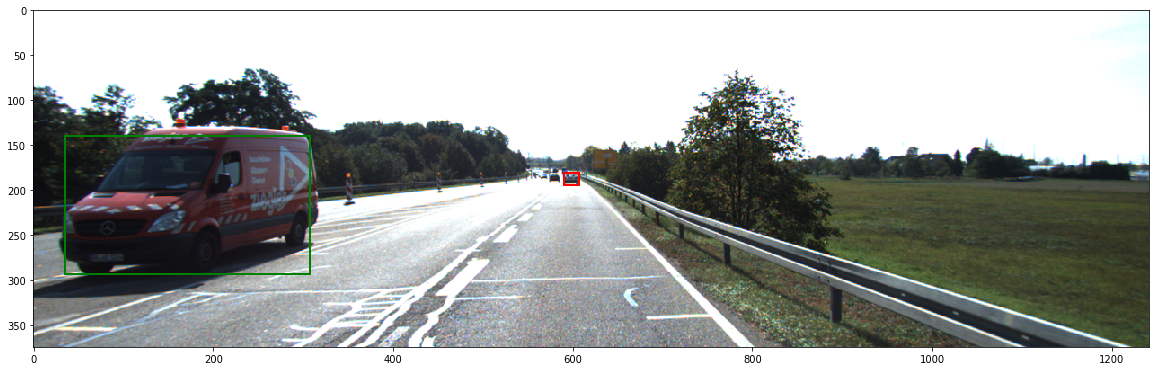

In [28]:
for 
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")
display_img(idx, kitti_val_dataset, save_path)